In [5]:
import numpy as np
from collections import Counter

class Node():
    #create node class
    def __init__(self, feature=None, threshold = None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold 
        self.left= left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None



class DecisionTree():
    def __init__(self, min_samples_split=15, max_depth=19, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        #..
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y, depth=0, node=None)

    def _grow_tree(self, X, y, depth, node):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Check the stopping criteria
        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idx = np.random.choice(n_feats, self.n_features, replace=False)
            # Finding best split
        best_threshold, best_feature = self._best_split(X, y, feat_idx)

         # Create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1, node="left")
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1, node="right")
        return Node(best_feature, best_threshold, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                #calc the info gain
                gain = self._information_gain()

                if gain>best_gain : 
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr
        return split_idx, split_threshold
    
    def _information_gain(self, y, X_column, threshold):
        #parent netrpoy
        parent_entropy = self._entropy(y)
        #create children
        left_idx, right_idx = self._split(X_column, threshold)
        #?
        if len(left_idx) == 0 or len(right_idx)==0 : return 0

        #calc the wighthed avg of children
        n = len(y)
        n_l,n_r = len(left_idx),len(right_idx)
        e_l, e_r = self._entropy(y[left_idx]), self._entropy(y[right_idx])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        #calc IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column,  split_threshold):
        left_idxs = np.argwhere(X_column<=split_threshold).flatten()
        right_idxs = np.argwhere(X_column > split_threshold).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        hist /= len(y)
        return -np.sum([p*np.log(p) for p in hist if p>0])

    def _most_common_label(self, y):
        #..gives tuple of most common feature nad its value
        counter =Counter(y)
        value = counter.most_common(1)[0][0]
        return value
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [6]:
import numpy as np
from decision_trees import DecisionTree
class RandomForest:
    def __init__(self, n_trees=144, min_samples_split=15, max_depth=19, n_features=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                                max_depth=self.max_depth,
                                n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        idxs = np.random.choice(len(X), size=len(X), replace=True)
        return X.iloc[idxs], y.iloc[idxs]

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

    def _most_common_label(self, y):
        return np.bincount(y.astype('int64')).argmax()



In [10]:
#from random_forest import RandomForest
from cleaning import data_new, X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
import numpy as np

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

clf = RandomForest(n_trees=144,min_samples_split=15, max_depth=19, n_features=None)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy(y_test, y_pred)
print(acc)


0.71900826446281


In [8]:
# creating a RF classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print("Random Forest:\n", report)

Random Forest:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76       136
           1       0.69      0.64      0.67       106

    accuracy                           0.72       242
   macro avg       0.71      0.71      0.71       242
weighted avg       0.72      0.72      0.72       242



In [6]:
# # import support vector classifier 
# # "Support Vector Classifier"
# from sklearn.svm import SVC  
# clf = SVC(kernel='linear') 
 
# # fitting x samples and y classes 
# clf.fit(X_train, y_train) 
# predictions = clf.predict(X_test)

# acc = accuracy(y_test, predictions)
# print(acc)

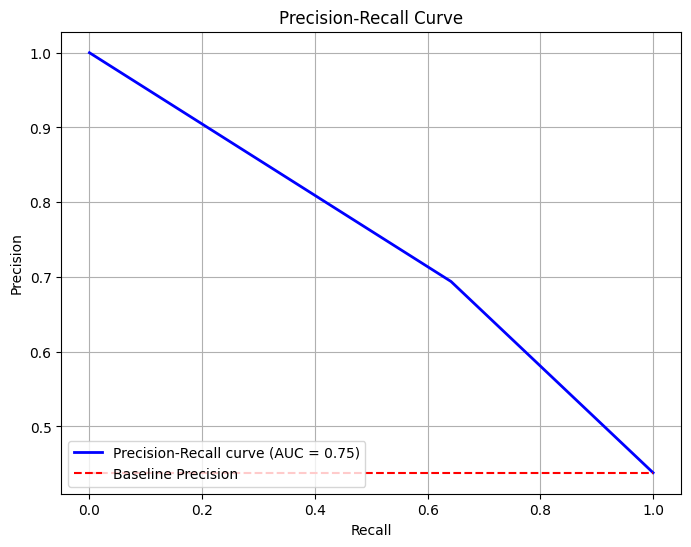

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Assuming y_test contains the true labels and y_pred contains the predicted probabilities or scores for the positive class
# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calculate area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Calculate baseline precision and recall
baseline_precision = sum(y_test) / len(y_test)
baseline_recall = 1.0  # Baseline recall is always 1

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [baseline_precision, baseline_precision], linestyle='--', color='red', label='Baseline Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
